# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [7]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [2]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [3]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [4]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [5]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [6]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


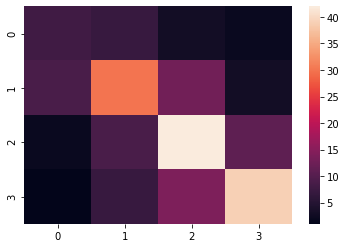

In [7]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [8]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [9]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [10]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [11]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [12]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


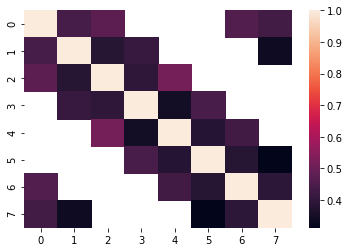

In [13]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [14]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [15]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [16]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

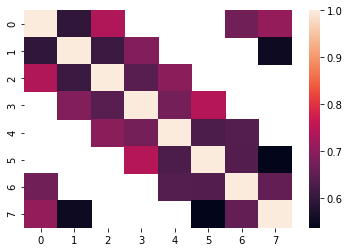

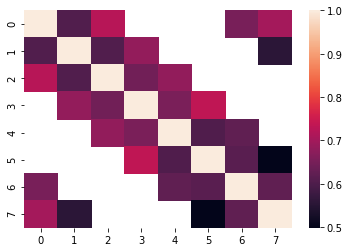

In [17]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [18]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [19]:
tujia = np.loadtxt("tujia_code.txt")
anno_tujia = AnnotationsContainer.from_array(tujia, missing_values=[0])

In [23]:
anno_tujia.annotations

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 0, 2],
       [2, 2, 2],
       [3, 2, 3],
       [3, 3, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [5, 2, 2],
       [2, 2, 2],
       [2, 3, 3],
       [3, 3, 3],
       [2, 2, 3],
       [0, 7, 2],
       [6, 2, 6],
       [2, 2, 2],
       [0, 5, 0],
       [2, 0, 0],
       [3, 2, 3],
       [3, 3, 2],
       [6, 3, 3],
       [2, 2, 2],
       [1, 1, 1],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 0],
       [0, 2, 2],
       [2, 2, 2],
       [2, 5, 5],
       [3, 3, 3],
       [2, 2, 2],
       [3, 3, 3],
       [3, 3, 3],
       [2, 2, 2],
       [0, 3, 2],
       [2, 2, 2],
       [2, 2, 2],
       [3, 3, 3],
       [2, 0, 2],
       [0, 3, 0],
       [0, 2, 2],
       [0, 6, 6],
       [2, 2, 2],
       [2, 2, 2],
       [2, 5, 5],
       [2,

In [24]:
anno_tujia.labels

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [25]:
anno_tujia.missing_values

[]

In [26]:
pyanno.measures.agreement.labels_frequency(anno_tujia.annotations, 8)

array([0.17      , 0.01666667, 0.53333333, 0.16666667, 0.01666667,
       0.02333333, 0.04333333, 0.03      ])

[[10.  1.  5.  2.  0.  1.  1.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 3.  0. 41.  2.  0.  3.  4.  0.]
 [ 0.  0.  2. 13.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.  1.  0.]
 [ 1.  0.  2.  0.  1.  0.  0.  1.]]


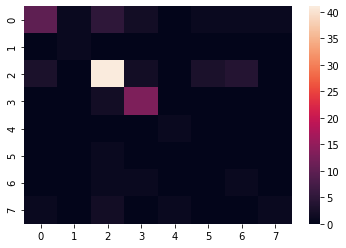

In [34]:
c_tujia = pyanno.measures.agreement.confusion_matrix(anno_tujia.annotations[:,0], anno_tujia.annotations[:,1],8)
print(c_tujia)
ac_tujia = seaborn.heatmap(c_tujia)
plt.show()

In [35]:
scotts_pi(anno_tujia.annotations[:,0], anno_tujia.annotations[:,1])

0.516762307459982

In [36]:
fleiss_kappa(anno_tujia.annotations[::])

0.6132315521628496

In [37]:
krippendorffs_alpha(anno_tujia.annotations[::])

0.4715619078603177

In [38]:
cohens_kappa(anno_tujia.annotations[:,0], anno_tujia.annotations[:,1])

0.5183624322697171

[[1.         0.51836243 0.62882771]
 [0.51836243 1.         0.69540055]
 [0.62882771 0.69540055 1.        ]]


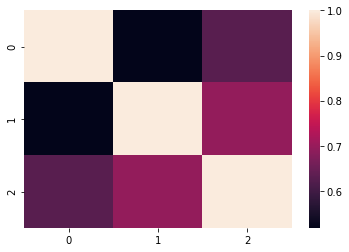

In [39]:
m_tujia = pairwise_matrix(cohens_kappa, anno_tujia.annotations)
print(m_tujia)
am_tujia = seaborn.heatmap(m_tujia)
plt.show()

In [40]:
cohens_weighted_kappa(anno_tujia.annotations[:,0], anno_tujia.annotations[:,1])

0.3851451057550418

In [41]:
pairwise_metric_average(cohens_weighted_kappa,anno_tujia.annotations)

0.5425443501543254

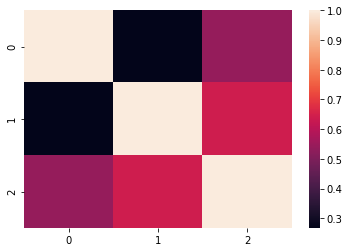

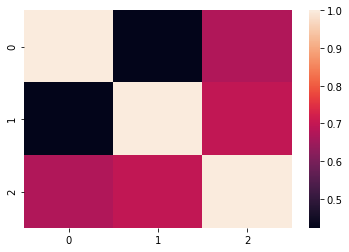

In [42]:
n2 = pairwise_matrix(pearsons_rho, anno_tujia.annotations)
m2 = pairwise_matrix(spearmans_rho, anno_tujia.annotations)
an2 = seaborn.heatmap(n2)
plt.show()
am2 = seaborn.heatmap(m2)
plt.show()

In [43]:
print(pairwise_metric_average(pearsons_rho,anno_tujia.annotations), pairwise_metric_average(spearmans_rho,anno_tujia.annotations))

0.4840461748513892 0.5982144381071666


The results are still acceptable. For most posts, these three coders have consistent views. The first and the second coder often generate different outcomes. 

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [44]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [174]:
noise = .2
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [146]:
dfTrain

,vect,category
257,"[0.5759896476777232, -0.06473085072094967]",1
754,"[-0.24971869747547076, -0.038261445812120376]",0
852,"[-0.6430472218474612, 0.8240020457137456]",0
133,"[-0.7866988541081188, -0.6264655403153532]",1
985,"[0.6553696914194833, 0.7055863188206221]",1
...,...,...
584,"[-0.8819549969027058, 0.5864433230475273]",0
944,"[0.5426241821809193, -0.7348142884579292]",0
716,"[-1.1524136407115932, 0.3526017038344134]",0
68,"[-0.13499593728739817, -0.3343579913876692]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [47]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


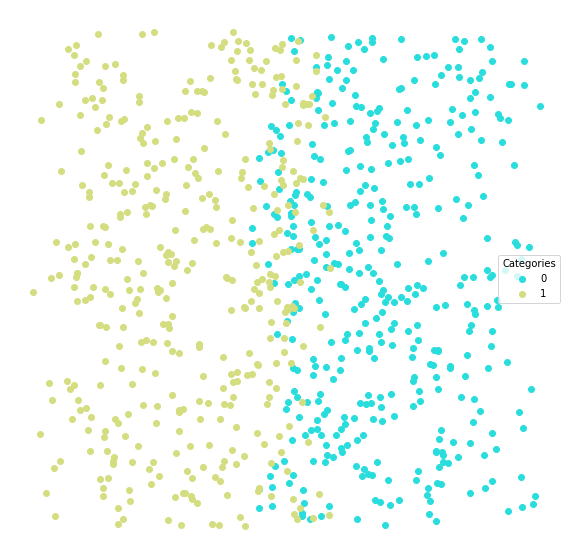

In [175]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [186]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [179]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [187]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [106]:
dfTrain['vect']

775       [5.215261547671464, -3.7345253944573105]
1971    [-0.9908917264863288, -0.8508383296541093]
782     [-1.7466688390309995, 0.41455427646526344]
102       [0.7183227815139709, -6.701465471404549]
1508    [-1.5136736628507825, -2.0103765018123316]
                           ...                    
1496     [-0.309802460822291, -1.6009575731773573]
132       [3.9574386163568986, -7.893128899210227]
21        [3.7088483044918044, -6.689275008137752]
2421      [0.6660611048597592, -6.586511033904231]
490        [4.607290076804485, -5.244537780764794]
Name: vect, Length: 2000, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [107]:
np.stack(dfTrain['vect'])

array([[ 5.21526155, -3.73452539],
       [-0.99089173, -0.85083833],
       [-1.74666884,  0.41455428],
       ...,
       [ 3.7088483 , -6.68927501],
       [ 0.6660611 , -6.58651103],
       [ 4.60729008, -5.24453778]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [188]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.145,0.854419,0.861702,0.799566,0.835052
1,0.145,0.854419,0.849057,0.806894,0.873786


This lets us look at which classes do better:

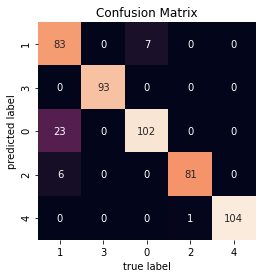

In [116]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

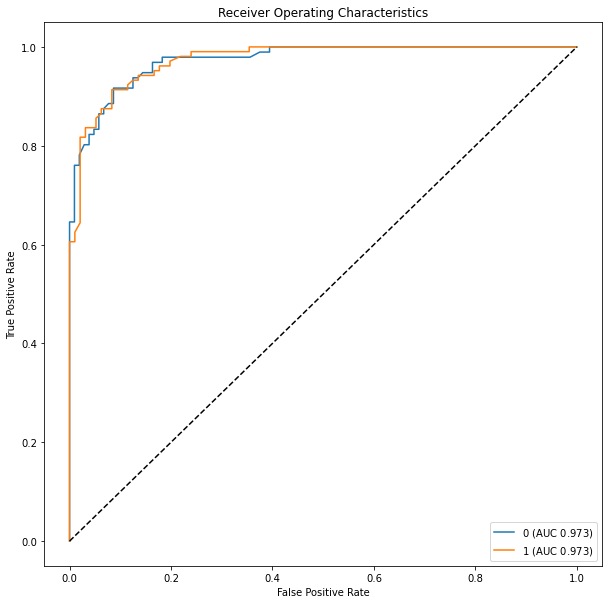

In [172]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


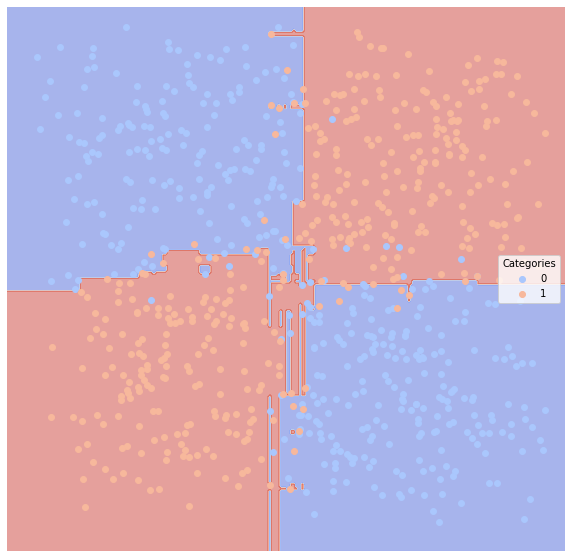

In [173]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks), you can set a `dataDirectory=` argument to match the path on Colab.

In [58]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Reddit data
Converting to vectors


/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [59]:
'../data/reddit.csv'

'../data/reddit.csv'

In [60]:
dfTrain

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
1071,1071,tortuga721,False,126,Weeaboo Tales: stories about the extreme fans ...,I can't stop reading these stories so I though...,"""No. I want it that way.""",https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[I, ca, n't, stop, reading, these, stories, so...","[stop, reading, stories, thought, contribute, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1239,1239,_sad_dad_,False,4388,Relationships,My original post can be found here: https://ww...,"UPDATE: Me [60 M] with my daughter [19 F], she...",https://www.reddit.com/r/relationships/comment...,Relationships,"[My, original, post, can, be, found, here, htt...","[original, post, found, https://www.reddit.com...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,15,samololo,False,8167,Tales From Tech Support,It work for a small IT company providing websi...,"I never use those, i won't pay for it!",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[It, work, for, a, small, IT, company, providi...","[work, small, company, providing, website, ema...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
82,82,DuckTalesWoooHooo,False,4941,Tales From Tech Support,A technician from Australia's largest telecomm...,"""How do I open Windows Command Prompt?"" - said...",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[A, technician, from, Australia, 's, largest, ...","[technician, australia, largest, telecommunica...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
902,902,OhGollyAThrowaway,False,193,Weeaboo Tales: stories about the extreme fans ...,"(Longtime lurker, first time poster, made a th...",My personal run-in with a Weeaboo.,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[Longtime, lurker, first, time, poster, made, ...","[longtime, lurker, time, poster, throwaway, et...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
703,703,[deleted],False,32,Bad Roommates: Tales of Irritation,"There's not really much point to this post, I ...",I'm worried.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[There, 's, not, really, much, point, to, this...","[point, post, want, chest, semester, finally, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
921,921,DanillaIce,False,179,Weeaboo Tales: stories about the extreme fans ...,"Okay, so, I'd been debating about finally putt...","Why I never joined an anime club/society, aka:...",https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[Okay, so, I, 'd, been, debating, about, final...","[okay, debating, finally, putting, found, subr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
433,433,gowronatemybaby7,False,82,Bad Roommates: Tales of Irritation,"In grad school, I lived with one of my best fr...",Operation Crystal Freedom,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[In, grad, school, I, lived, with, one, of, my...","[grad, school, lived, best, friends, dudes, bu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
281,281,zinge,False,3041,Tales From Tech Support,This is my second one today ([tada!](https://w...,Reading comprehension is a lost art.,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[This, is, my, second, one, today, tada!](http...","[today, tada!](https://www.reddit.com, r, tale...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [61]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [62]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [63]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.015625,0.985054,0.947368,0.937516,0.986301
Relationships,0.021875,0.972917,0.950617,0.924344,0.962500
Tales From Tech Support,0.003125,0.993333,1.000000,0.989792,0.986667
Weeaboo Tales,0.009375,0.983696,1.000000,0.976766,0.967391


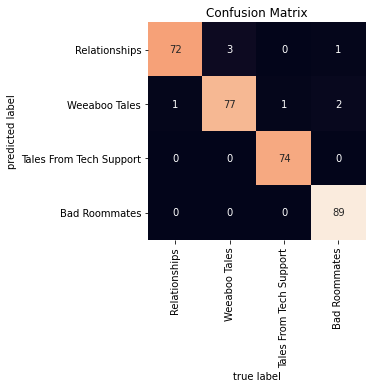

In [64]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

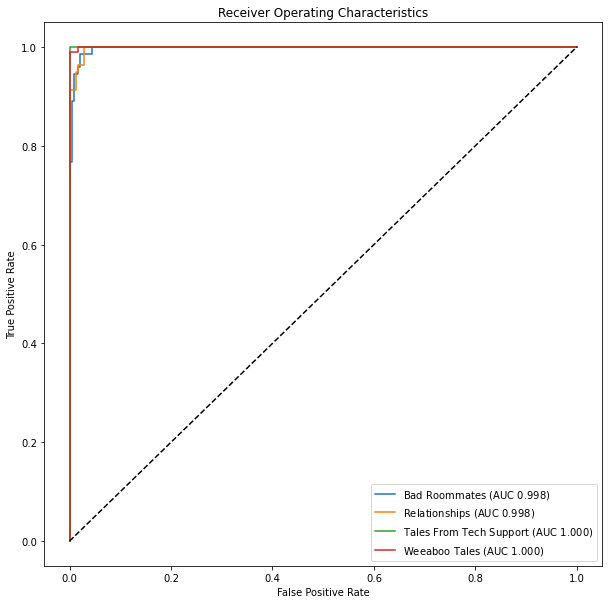

In [65]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

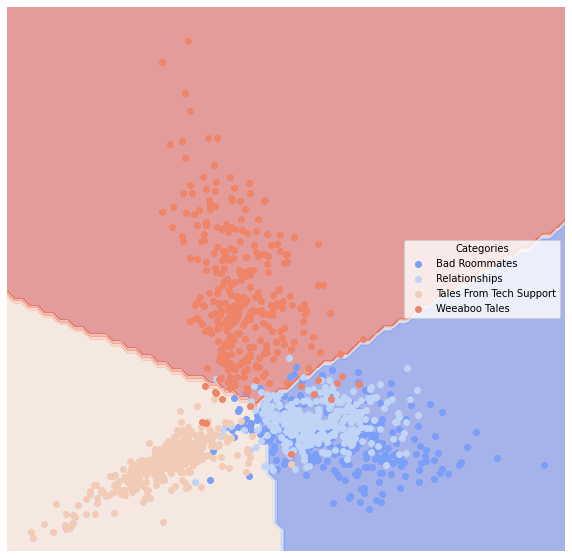

In [66]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [214]:
noise = .2
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(2), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

In [215]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.002,0.994624,1.000000,0.991247,0.989247
1,0.002,0.995192,1.000000,0.992385,0.990385
2,0.004,0.997442,0.981982,0.981982,1.000000
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.000,1.000000,1.000000,1.000000,1.000000


By switching between the four data patterns (andSplit, xorSplit, targetSplit, and multiBlobs) and changing the number of noise, I generated several distinct datasets. From my observations, the Linear Support Vector Classification works best for the "multiBlobs" data pattern based on the calculated accuracy rates. The decision tree works best for the "xorSplit" data pattern based on the calculated accuracy rates. The Poly Support Vector Classification works best for the "andSplit" data pattern based on the calculated accuracy rates. The Random Forest works best for the "targetSplit" data pattern based on the calculated accuracy rates. 

In [249]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [256]:
#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.077372,0.831445,0.728261,0.554491,0.705263
not spam,0.077372,0.831445,0.952782,0.948907,0.957627


By switching different real datasets, I find that Random Forest works best for the Reddit data based on the calculated accuracy rates. The logistic regression works best for the News data based on the calculated accuracy rates. The Linear SVC works best for the Senator(2) data based on the calculated accuracy rates. Decision Tree and Random Forest work best for the Senator (5) data based on the calculated accuracy rates. The Linear SVC and neural network work best for the Spam data based on the calculated accuracy rates.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [257]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [258]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [259]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [260]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [261]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [262]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [263]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [264]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [265]:
TFVects.shape

(1367, 11251)

We can save this in the dataframe to make things easier

In [266]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [267]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [268]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


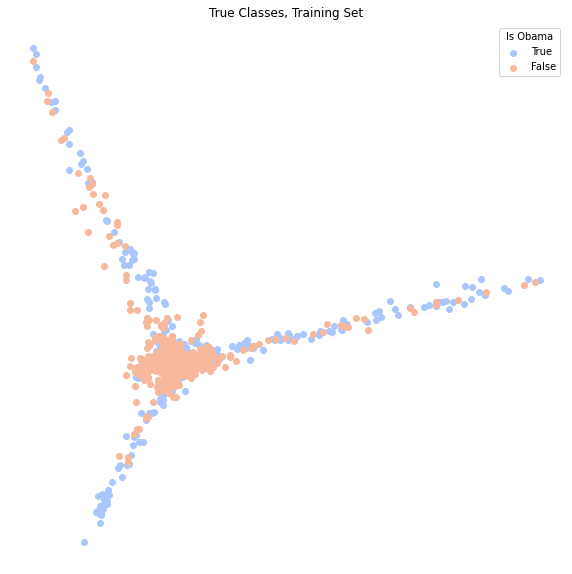

In [269]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

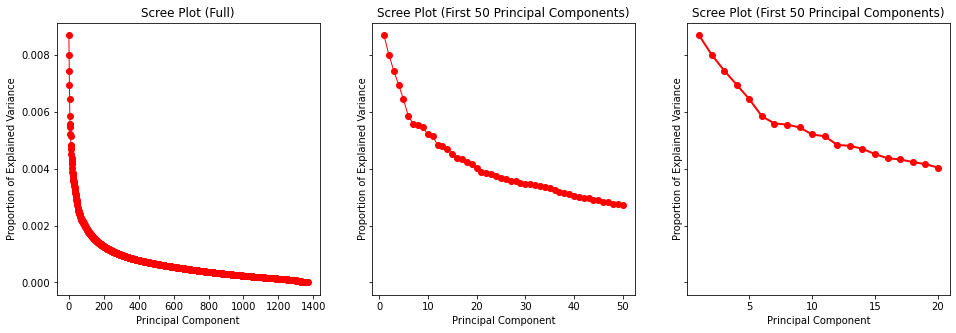

In [270]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [271]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [272]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [273]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6583760058522312

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [274]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6637426900584795

Slightly poorer. How about using more dimensions (40)?

In [275]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7351865398683248
Testing:
0.7456140350877193


Or still more (100)?

In [276]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.803218727139722
Testing:
0.7953216374269005


Or even more (200)!

In [277]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8653986832479883
Testing:
0.8362573099415205


This is becoming ridiculous (400)!

In [278]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9144111192392099
Testing:
0.8538011695906432


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [279]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9612289685442575


Train the model using training data, and then test it on the testing data.

In [280]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8596491228070176


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [413]:
tujia = pandas.read_csv('tujiaset1.csv', index_col=False)

In [414]:
tujia[:10]

,content,category
0,从古籍看土家族之“冉家蛮” 从古籍看土家族之“冉家蛮” 本帖资料来源：《百苗图抄本汇编》杨庭...,culture
1,从古籍看土家族之“蛮人” 从古籍看土家族之“蛮人” 本帖资料来源：《百苗图抄本汇编》杨庭硕/...,culture
2,从古籍看土家族之《苗防备览》 本帖资料来源：《苗防备览第九卷》清朝后期，作者严如熤（1759...,culture
3,从古籍看土家族之《楚南苗志》 本帖资料来源：《楚南苗志卷六<土志>》湖北巡抚采进本，清朝段汝...,culture
4,湖南世居少数民族之土家族篇 资料来源：湘西州民宗委网站http://mw.xxz.gov.c...,culture
5,土家族牛头宴 资料来源：湘西州民宗委网站http://mw.xxz.gov.cn/mzzs/...,culture
6,土家族传统文化视频介绍解说集 资料来源：湘西州民宗委网站http://mw.xxz.gov....,networking
7,从古籍中看土家族之《皇清职贡图》 土家族之《皇清职贡图》清乾隆十六年至二十八年，傅恒、董诰等...,culture
8,土家语的特点 本帖资料来源：《湘西地区少数民族语言态度研究》瞿继勇 著陕西师范大学 博士学位论文,culture
9,土家语山歌《bifzivsarnif keirboxzaor》 作词：田秀珍演唱：田秀珍,language


In [286]:
import jieba
tujia['tokenized_sents'] = tujia['content'].apply(lambda x: jieba.lcut(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/5k/y_c_3dn11vz1l1xv724bslpc0000gn/T/jieba.cache
Loading model cost 0.866 seconds.
Prefix dict has been built successfully.


In [287]:
tujia[:10]

,content,category,tokenized_sents
0,从古籍看土家族之“冉家蛮” 从古籍看土家族之“冉家蛮” 本帖资料来源：《百苗图抄本汇编》杨庭...,culture,"[从, 古籍, 看, 土家族, 之, “, 冉家蛮, ”, , 从, 古籍, 看, 土家族..."
1,从古籍看土家族之“蛮人” 从古籍看土家族之“蛮人” 本帖资料来源：《百苗图抄本汇编》杨庭硕/...,culture,"[从, 古籍, 看, 土家族, 之, “, 蛮, 人, ”, , 从, 古籍, 看, 土家..."
2,从古籍看土家族之《苗防备览》 本帖资料来源：《苗防备览第九卷》清朝后期，作者严如熤（1759...,culture,"[从, 古籍, 看, 土家族, 之, 《, 苗, 防备, 览, 》, , 本帖, 资料, ..."
3,从古籍看土家族之《楚南苗志》 本帖资料来源：《楚南苗志卷六<土志>》湖北巡抚采进本，清朝段汝...,culture,"[从, 古籍, 看, 土家族, 之, 《, 楚南, 苗志, 》, , 本帖, 资料, 来源..."
4,湖南世居少数民族之土家族篇 资料来源：湘西州民宗委网站http://mw.xxz.gov.c...,culture,"[湖南, 世居, 少数民族, 之, 土家族, 篇, , 资料, 来源, ：, 湘西, 州民..."
5,土家族牛头宴 资料来源：湘西州民宗委网站http://mw.xxz.gov.cn/mzzs/...,culture,"[土家族, 牛头, 宴, , 资料, 来源, ：, 湘西, 州民宗委, 网站, http,..."
6,土家族传统文化视频介绍解说集 资料来源：湘西州民宗委网站http://mw.xxz.gov....,networking,"[土家族, 传统, 文化, 视频, 介绍, 解说, 集, , 资料, 来源, ：, 湘西,..."
7,从古籍中看土家族之《皇清职贡图》 土家族之《皇清职贡图》清乾隆十六年至二十八年，傅恒、董诰等...,culture,"[从, 古籍, 中看, 土家族, 之, 《, 皇清职, 贡图, 》, , 土家族, 之, ..."
8,土家语的特点 本帖资料来源：《湘西地区少数民族语言态度研究》瞿继勇 著陕西师范大学 博士学位论文,culture,"[土家, 语, 的, 特点, , 本帖, 资料, 来源, ：, 《, 湘西, 地区, 少数..."
9,土家语山歌《bifzivsarnif keirboxzaor》 作词：田秀珍演唱：田秀珍,language,"[土家, 语, 山歌, 《, bifzivsarnif, , keirboxzaor, 》..."


In [288]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(tujia, test_size=holdBackFraction)

In [289]:
print(len(train_data_df))
print(len(test_data_df))

80
20


In [416]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=1, norm='l1')
TFVects = TFVectorizer.fit_transform(train_data_df['content'])

In [417]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [418]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [419]:
train_data_df['pca'] = [r for r in reduced_data]

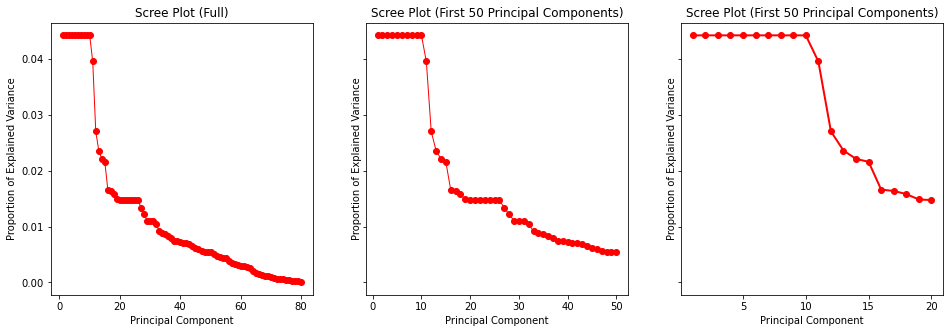

In [420]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [421]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [423]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df.dropna()['pca_reduced_10'], axis=0), train_data_df.dropna()['category'])

LogisticRegression()

In [424]:
logistic.score(np.stack(train_data_df.dropna()['pca_reduced_10'], axis=0), train_data_df.dropna()['category'])

0.5512820512820513

In [425]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['content'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.55

In [426]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df.dropna()['pca_reduced_40'], axis=0), train_data_df.dropna()['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df.dropna()['pca_reduced_40'], axis=0), train_data_df.dropna()['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df.dropna()['pca_reduced_40'], axis=0), test_data_df.dropna()['category']))

Training:
0.5256410256410257
Testing:
0.55


not perform well because of the small traning set.

In [ ]:
lucem_illud.plotMultiROC(logistic, dfTest)

In [ ]:
lucem_illud.plotregions(logistic, test_data_df)

In [ ]:
lucem_illud.plotConfusionMatrix(logistic, test_data_df)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

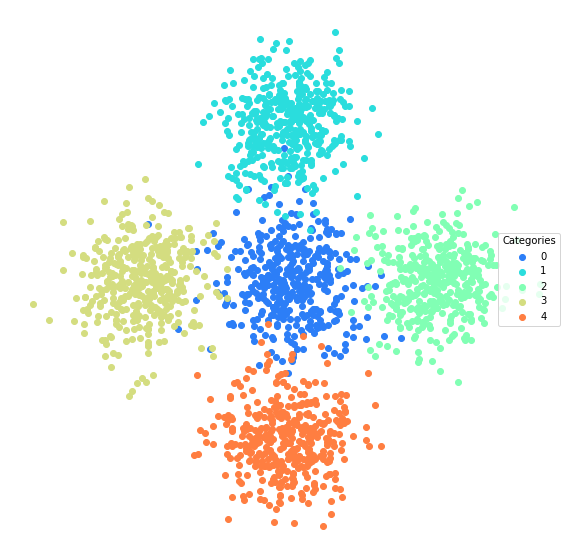

In [376]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [377]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

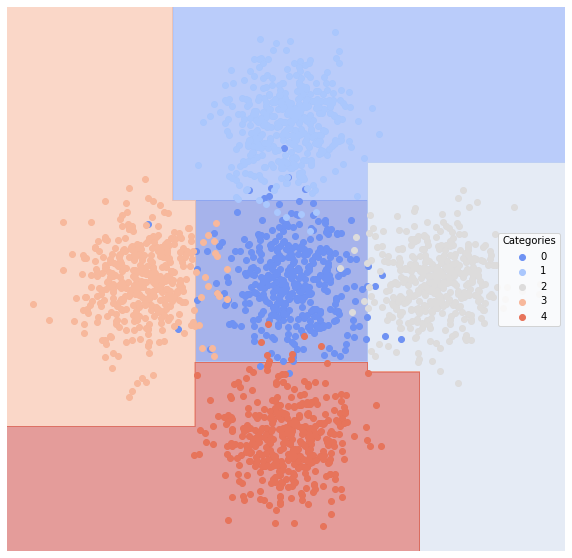

In [378]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [379]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.034,0.971196,0.866071,0.852575,0.979798
1,0.008,0.983750,0.989796,0.966102,0.970000
2,0.008,0.983450,0.989583,0.965290,0.969388
3,0.016,0.956989,1.000000,0.929978,0.913978
4,0.006,0.989627,0.990826,0.976811,0.981818


Lets look at accuracy:

In [380]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.964

What happens if we trim the tree?

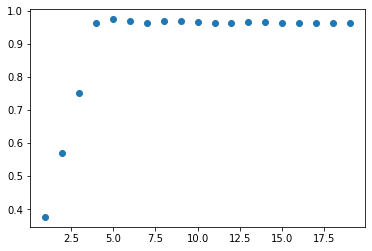

In [381]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [382]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [383]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

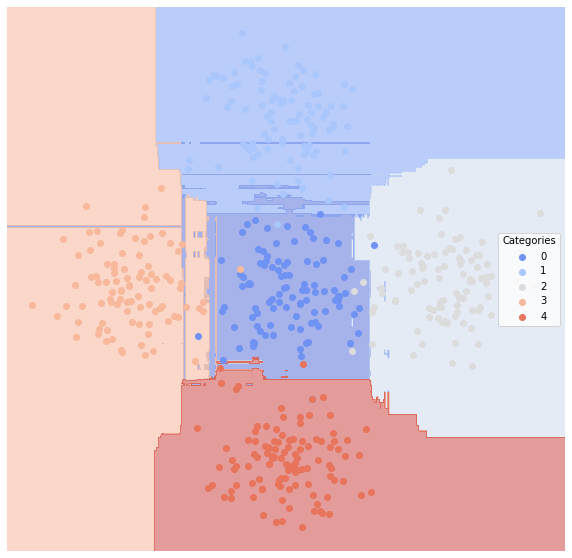

In [384]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [385]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.024,0.969823,0.922330,0.893064,0.959596
1,0.004,0.993750,0.990000,0.982100,0.990000
2,0.008,0.983450,0.989583,0.965290,0.969388
3,0.006,0.988019,0.989130,0.971859,0.978495
4,0.006,0.989627,0.990826,0.976811,0.981818


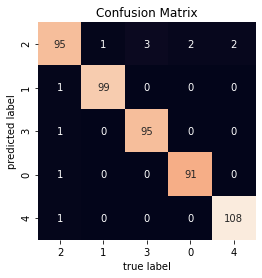

In [386]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

The training set is so small that we may not observe meaningful patterns. But I don't have labor to do the labelling!

Overall, I need to say that all approaches are not supposed to work well since the training dataset is too small. And most posts in this small sample belong to "culture" category, which makes this traning data more uninformative.

In [387]:
tujia = pandas.read_csv('tujiaset1.csv', index_col=False)
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(tujia, test_size=holdBackFraction)

In [388]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=1, norm='l1')
TFVects = TFVectorizer.fit_transform(train_data_df['content'])

In [389]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [390]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [391]:
train_data_df['pca'] = [r for r in reduced_data]

In [393]:
train_data_df[:10]

,content,category,vect,pca
2,从古籍看土家族之《苗防备览》 本帖资料来源：《苗防备览第九卷》清朝后期，作者严如熤（1759...,culture,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.747114559387407e-17, 7.233858122345291e-19,..."
59,冬天的味道！ 冬天的味道！,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.18545539871797181, 0.05899246741480919, -0...."
41,【土家族】文献对土家语的记载 土家族语言历史悠久，许多史籍如方志、家谱中皆有记录。《隋书·地...,language,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.153200337091001e-17, 3.274290560906224e-17..."
50,关于酱香饼的种种疑惑，求吧友解疑。 各种费解，难道是我又孤陋寡闻了？土家族可是南方的民族啊。...,culture,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.6837533851373835e-17, -2.081668171172169e-..."
72,土家年 土家年是湖南省湘西土家族苗族自治州的土家族一个重要而古老的节日，在千百年的历史发展中...,culture,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.7867651802561128e-16, 9.497611030973021e-1..."
6,土家族传统文化视频介绍解说集 资料来源：湘西州民宗委网站http://mw.xxz.gov....,networking,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.5439038936193598e-16, -1.3010426069826056e-..."
35,土家族掉渣饼 群里有知道土家族掉渣饼的吗？ 我知道啊！,culture,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.122638424559516e-15, -1.9905951886833866e-1..."
42,土家族民俗之婚姻,language,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.16347561633399585, 0.17140560715624806, 0...."
92,相亲了，看上说话？ 本人 22 可以分开出吗？我想要条腿,networking,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.194034422677086e-17, -1.387778780781446e-1..."
38,关于苗族吧部分深水客对土家族的诋毁的说明 毕兹卡（土家族）是国家民委于1956年就已经完成民...,admin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.632783294297959e-17, -8.153200337090995e-17..."


In [395]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4, random_state=0)
clf_tree.fit(np.stack(train_data_df.dropna()['vect'], axis =0), train_data_df.dropna()['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

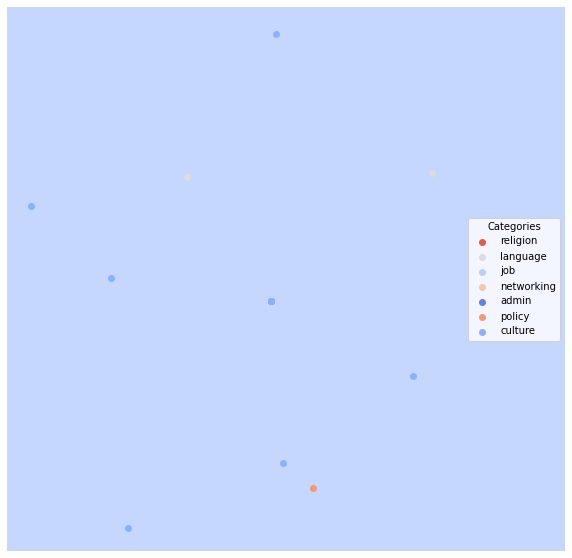

In [396]:
lucem_illud.plotregions(clf_tree, train_data_df.dropna())

In [397]:
lucem_illud.evaluateClassifier(clf_tree, train_data_df.dropna())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
religion,0.000000,1.000000,1.000000,1.000000,1.000000
language,0.153846,0.571429,1.000000,0.296703,0.142857
job,0.000000,1.000000,1.000000,1.000000,1.000000
networking,0.166667,0.500000,0.000000,0.166667,0.000000
admin,0.051282,0.500000,0.000000,0.051282,0.000000
policy,0.051282,0.500000,0.000000,0.051282,0.000000
culture,0.423077,0.554054,0.554054,0.554054,1.000000


In [399]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['content'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

In [400]:
sklearn.metrics.accuracy_score(test_data_df.dropna()['category'],clf_tree.predict(np.stack(test_data_df.dropna()['vect'], axis = 0)))

0.55

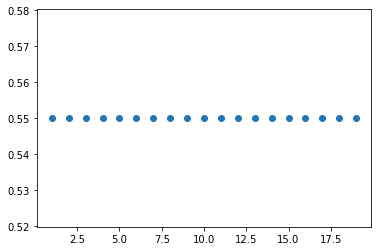

In [402]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df.dropna()['vect'], axis =0), train_data_df.dropna()['category'])
    score = sklearn.metrics.accuracy_score(test_data_df.dropna()['category'], tree2.predict(np.stack(test_data_df.dropna()['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [403]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [404]:
bag.fit(np.stack(train_data_df.dropna()['vect'], axis =0), train_data_df.dropna()['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

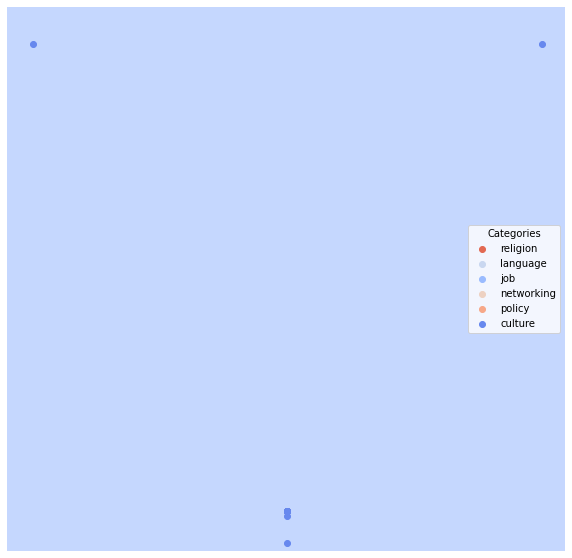

In [405]:
lucem_illud.plotregions(bag, test_data_df.dropna())

In [406]:
lucem_illud.evaluateClassifier(bag, test_data_df.dropna())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
religion,0.05,0.5,0.00,0.05,0.0
language,0.20,0.5,0.00,0.20,0.0
job,0.05,0.5,0.00,0.05,0.0
networking,0.05,0.5,0.00,0.05,0.0
policy,0.10,0.5,0.00,0.10,0.0
culture,0.45,0.5,0.55,0.55,1.0


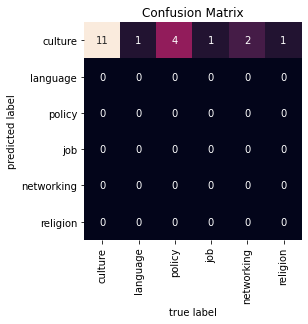

In [407]:
lucem_illud.plotConfusionMatrix(bag, test_data_df.dropna())

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [431]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [432]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admitting, lot, admitting, morals, situationa..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognized, holy, days, like, passover..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [433]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [434]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [435]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [436]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [437]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.349013,0.632446,0.412791,0.358129,0.590437
soc.religion.christian,0.264228,0.537885,0.592593,0.305584,0.102128
comp.graphics,0.304297,0.619638,0.441667,0.348736,0.452991
talk.religion.misc,0.297329,0.597667,0.279070,0.220878,0.435644


And lets look at the testing data

In [438]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.26218097447795824


Let's produce another confusion matrix:

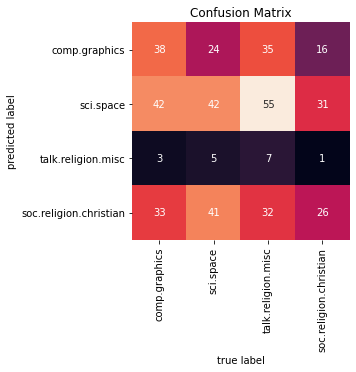

In [439]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

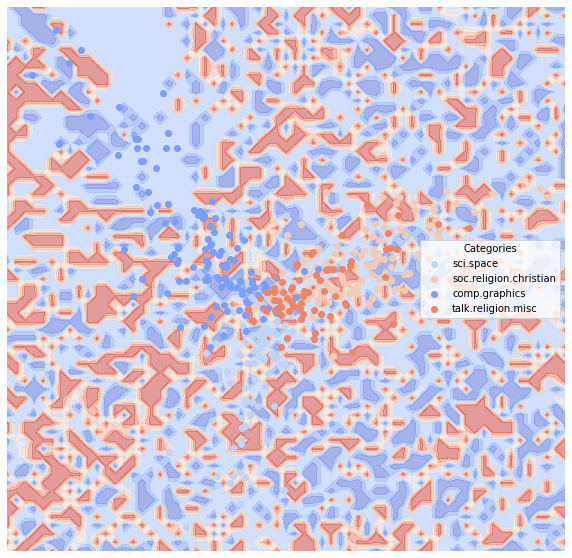

In [440]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [441]:
tujia = pandas.read_csv('tujiaset1.csv', index_col=False)
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(tujia, test_size=holdBackFraction)
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=1, norm='l1')
TFVects = TFVectorizer.fit_transform(train_data_df['content'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

In [442]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [445]:
clf_knearest.fit(np.stack(train_data_df.dropna()['vect'], axis = 0), train_data_df.dropna()['category'])

KNeighborsClassifier(n_neighbors=15)

In [446]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df.dropna())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
religion,0.012821,0.5,0.000000,0.012821,0.0
language,0.230769,0.5,0.000000,0.230769,0.0
job,0.025641,0.5,0.000000,0.025641,0.0
networking,0.141026,0.5,0.000000,0.141026,0.0
admin,0.038462,0.5,0.000000,0.038462,0.0
policy,0.064103,0.5,0.000000,0.064103,0.0
culture,0.512821,0.5,0.487179,0.487179,1.0


In [447]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['content'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df.dropna()['vect'], axis=0), test_data_df.dropna()['category']))

Testing score:
0.7


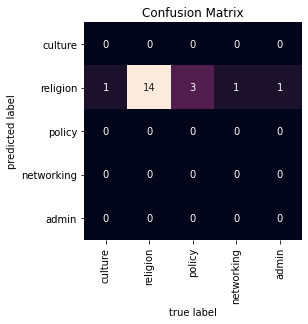

In [448]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df.dropna())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

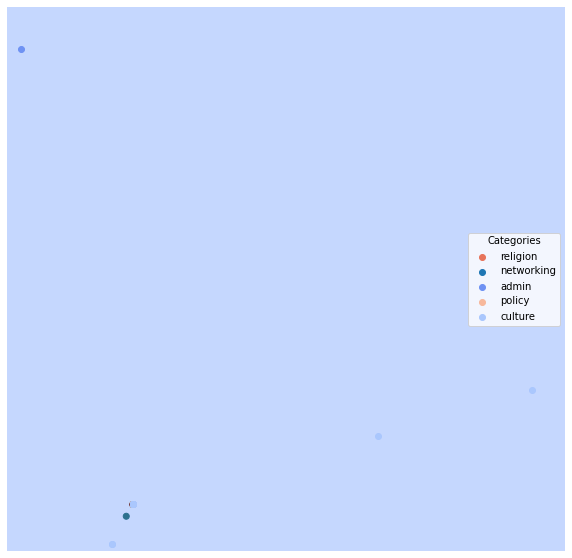

In [449]:
lucem_illud.plotregions(clf_knearest, test_data_df.dropna())

KNN is a method of classification (supervised), while k-means is used for clustering (unsupervised). Clustering attempts to group or cluster objects based on some rule defining the similarity between the objects. For clustering, the group labels are not known a priori. For classification, the group labels are known for a trained sample.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [450]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [451]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [452]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [453]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [454]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.021875,0.961314,0.987013,0.933543,0.926829
Tales From Tech Support,0.018750,0.983454,0.943182,0.935078,0.988095
Bad Roommates: Tales of Irritation,0.009375,0.989252,0.973684,0.963827,0.986667
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006250,0.991596,0.987342,0.977969,0.987342


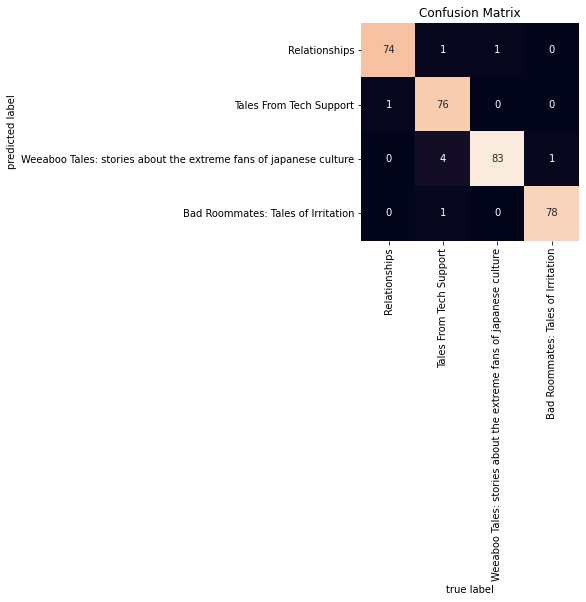

In [455]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

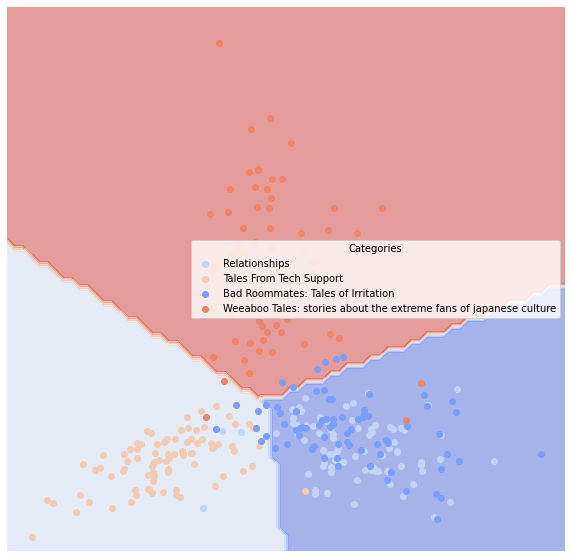

In [456]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [457]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [458]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.03750,0.946813,0.937500,0.879345,0.914634
Tales From Tech Support,0.01250,0.987692,0.965116,0.956752,0.988095
Bad Roommates: Tales of Irritation,0.01875,0.973878,0.960000,0.930975,0.960000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.00625,0.991596,0.987342,0.977969,0.987342


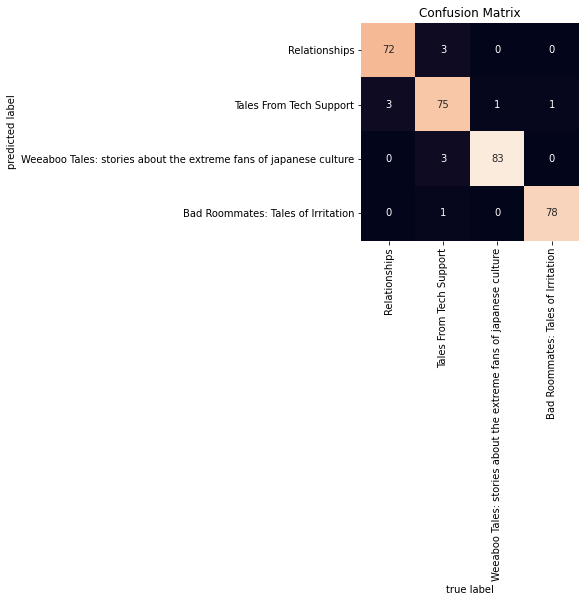

In [459]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

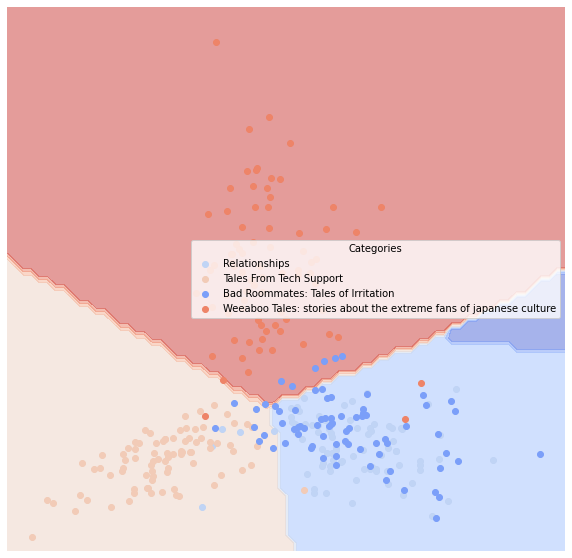

In [460]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [461]:
tujia = pandas.read_csv('tujiaset1.csv', index_col=False)
tujia = tujia.dropna()
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(tujia, test_size=holdBackFraction)
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=1, norm='l1')
TFVects = TFVectorizer.fit_transform(train_data_df['content'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

In [464]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [465]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['content'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

In [466]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
culture,0.5,0.454545,0.526316,0.528469,0.909091
language,0.2,0.500000,0.000000,0.200000,0.000000
policy,0.1,0.500000,0.000000,0.100000,0.000000
networking,0.2,0.470588,0.000000,0.150000,0.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


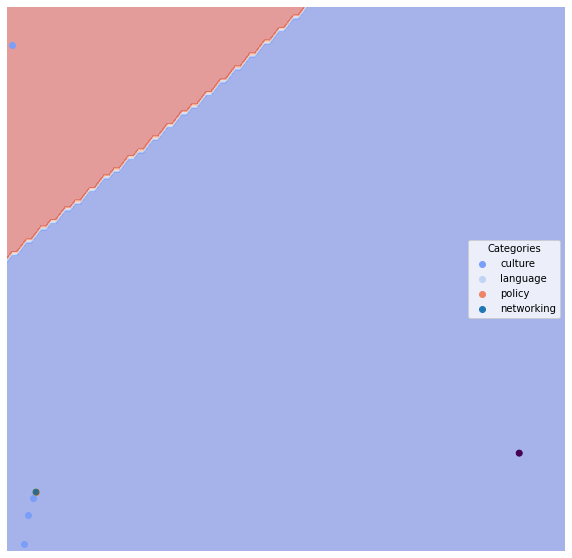

In [467]:
lucem_illud.plotregions(clf_nn, test_data_df)

Comparing the error rates, I feel like the decision tree method performs the best for this dataset. 

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [11]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")


label: NEGATIVE, with score: 0.9991000294685364
label: POSITIVE, with score: 0.9998999834060669


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
! pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [3]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [4]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

NameError: name 'context' is not defined

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [5]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

TypeError: 'BertTokenizerFast' object is not callable

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [12]:
tujia = pandas.read_csv('tujiaset1.csv', index_col=False)
tujia = tujia.dropna()

In [13]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("我恨你")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("我爱你")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")


label: NEGATIVE, with score: 0.7412999868392944
label: NEGATIVE, with score: 0.7412999868392944


This seems not work in Chinese. I'd like to try another NLP models to do sentiment anaysis. 
https://stanfordnlp.github.io/stanza/index.html.

In [19]:
import stanza
stanza.download('zh')
stanza_nlp = stanza.Pipeline('zh')

2022-02-17 00:57:58 INFO: "zh" is an alias for "zh-hans"
2022-02-17 00:57:58 INFO: Downloading default packages for language: zh-hans (Simplified_Chinese)...


2022-02-17 00:58:00 INFO: File exists: /Users/nyjiang/stanza_resources/zh-hans/default.zip.
2022-02-17 00:58:06 INFO: Finished downloading models and saved to /Users/nyjiang/stanza_resources.
2022-02-17 00:58:06 INFO: "zh" is an alias for "zh-hans"
2022-02-17 00:58:06 INFO: Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package   |
-------------------------
| tokenize  | gsdsimp   |
| pos       | gsdsimp   |
| lemma     | gsdsimp   |
| depparse  | gsdsimp   |
| sentiment | ren       |
| ner       | ontonotes |

2022-02-17 00:58:06 INFO: Use device: cpu
2022-02-17 00:58:06 INFO: Loading: tokenize
2022-02-17 00:58:06 INFO: Loading: pos
2022-02-17 00:58:06 INFO: Loading: lemma
2022-02-17 00:58:07 INFO: Loading: depparse
2022-02-17 00:58:07 INFO: Loading: sentiment
2022-02-17 00:58:08 INFO: Loading: ner
2022-02-17 00:58:09 INFO: Done loading processors!


In [27]:
nlp = stanza.Pipeline(lang='zh', processors='tokenize, sentiment', tokenize_pretokenized=True)
tujia_lst = tujia['content'].astype(str).values.tolist()
doc = nlp(tujia_lst)
for i, sentence in enumerate(doc.sentences[:20]):
    print(i, tujia['content'][i], sentence.sentiment)

2022-02-17 01:05:45 INFO: "zh" is an alias for "zh-hans"
2022-02-17 01:05:45 INFO: Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| sentiment | ren     |

2022-02-17 01:05:45 INFO: Use device: cpu
2022-02-17 01:05:45 INFO: Loading: tokenize
2022-02-17 01:05:45 INFO: Loading: sentiment
2022-02-17 01:05:46 INFO: Done loading processors!


0 从古籍看土家族之“冉家蛮” 从古籍看土家族之“冉家蛮” 本帖资料来源：《百苗图抄本汇编》杨庭硕/潘盛之 编著 贵州人民出版社《八十二种苗图并说》 陈浩 著  清乾隆至嘉庆年间 2
1 从古籍看土家族之“蛮人” 从古籍看土家族之“蛮人” 本帖资料来源：《百苗图抄本汇编》杨庭硕/潘盛之 编著 贵州人民出版社《八十二种苗图并说》 陈浩 著 清乾隆至嘉庆年间 2
2 从古籍看土家族之《苗防备览》 本帖资料来源：《苗防备览第九卷》清朝后期，作者严如熤（1759—1826）清地理学家。湖南溆浦人。字炳文，一字苏亭，号乐园（一说字乐园）。曾就读岳麓书院。留心经世之学，精研天文，地理，兵法。清乾隆五十四年（1789）举优贡。 原版古籍书扫描图。 2
3 从古籍看土家族之《楚南苗志》 本帖资料来源：《楚南苗志卷六<土志>》湖北巡抚采进本，清朝段汝霖撰。汝霖字时斋，号梅亭，汉阳人。由举人历官建宁府知府。是书乃汝霖为湖南永绥同知时所作。 2
4 湖南世居少数民族之土家族篇 资料来源：湘西州民宗委网站http://mw.xxz.gov.cn/mzzs/201303/t20130327_69692.html 1、文化艺术： 　　神话、传说、故事、诗歌、音乐、舞蹈、雕塑、建筑、绣织等，构成土家族绚丽多彩、独具一格的文化艺术。土家语属汉藏语系藏缅语族。土家族民间文学主要有民间歌谣、传说、故事、诗歌等，其中，《摆手歌》、《梯玛歌》、《哭嫁歌》最具代表性。土家族地区素有“歌的海洋”的美称。土家山歌分情歌、哭嫁歌、摆手歌、诉苦歌、劳动歌、盘歌等多种，曲调优美动听，旋律朴素无华，感情真挚热烈。传统的《摆手舞》土家语称“社巴日”，古朴刚健，有鲜明的民族特色和浓厚的土家山乡气息，每年春节期间，大家聚在村寨中设的“摆手堂”前举行摆手舞会，多时达万人。土家族地区流行的剧种有茅古斯、傩愿戏、阳戏等。茅古斯是土家族古老而原始的戏剧，多在小摆手舞活动的间隙表演。乐器主要有唢呐、木叶、“咚咚喹”以及打击乐器“打溜子”。“咚咚喹”是土家族具有特色的乐器，声音柔和悦耳，曲调活泼欢快。土家族工艺美术主要有织锦、雕刻、绘画、剪纸，都具有浓郁的民族风格和较高的工艺水平。“西兰卡普”（土家语，即土花铺盖）是土家妇女借鉴鲜花、羽毛、晚霞和彩虹的自然色谱而精织的特有手工艺品，织工精巧，色彩绚丽。它和摆手舞一起被称作土家族人民的艺术

We can see that most posts are classified as "positive". "土家族民俗之哭嫁歌" was classified as negative, which makes sense in the context. From this perspective, I think pre-trained models like BERT can (1) add more functions for us to explore the data, and (2) learn more contextual information.